In [490]:
import matplotlib.pyplot as plt
import random
import math
import numpy as np

In [491]:
class Node:
    def __init__(self, type=None, value=None):
        self.type = type
        self.value = value
        self.children = []

    def evaluate(self, input_values, available_variables):
      if self.value is None:
          return 0
      elif isinstance(self.value, str):  # Handle operators and functions
          if self.value == '+':
              return self.children[0].evaluate(input_values, available_variables) + self.children[1].evaluate(input_values, available_variables)
          elif self.value == '-':
              return self.children[0].evaluate(input_values, available_variables) - self.children[1].evaluate(input_values, available_variables)
          elif self.value == '*':
              return self.children[0].evaluate(input_values, available_variables) * self.children[1].evaluate(input_values, available_variables)
          elif self.value == '/':
              divisor = self.children[1].evaluate(input_values, available_variables)
              if divisor != 0:
                  return self.children[0].evaluate(input_values, available_variables) / divisor
              else:
                  return 0
          elif self.value == '^':
              base = self.children[0].evaluate(input_values, available_variables)
              exponent = self.children[1].evaluate(input_values, available_variables)
              if base != 0 or (exponent >= 0 and exponent.imag == 0):
                  return base ** exponent
              else:
                  return 0
          elif self.value == 'sin':
              return math.sin(self.children[0].evaluate(input_values, available_variables))
          elif self.value == 'cos':
              return math.cos(self.children[0].evaluate(input_values, available_variables))
          else:
              return 0  # Return 0 for unknown operators/functions
      elif isinstance(self.value, (int, float)):  # Handle numeric constants
          return float(self.value)
      elif isinstance(self.value, dict):  # Handle variables
          variable_name = self.value['symbol']
          if variable_name in available_variables:
              index = available_variables.index(variable_name)
              return input_values[index]
      else:
          return 0  # Return 0 for unknown value types

    def print_function(self):
        if self.value is None:
            return '0'
        elif isinstance(self.value, str):
            if self.value in ('+', '-', '*', '/', '^'):
                return f"({self.children[0].print_function()} {self.value} {self.children[1].print_function()})"
            elif self.value in ('sin', 'cos'):
                return f"{self.value}({self.children[0].print_function()})"
            else:
                return '0'  # Return '0' for unknown operators/functions
        elif isinstance(self.value, (int, float)):
            return str(self.value)
        elif isinstance(self.value, dict):
            return self.value['symbol']
        else:
            return '0'  # Return '0' for unknown value types

In [492]:
def create_random_individual(max_depth, available_operators, available_variables):
    if max_depth <= 0 or random.random() < 0.1:  # Terminal node (constant or variable)
        if random.random() < 0.5:  # Generate constant
            value = random.uniform(-10, 10)
        else:  # Generate variable
            symbol = random.choice(available_variables)
            value = {'symbol': symbol}
        return Node(value=value)
    else:  # Function node (operator)
        operator = random.choice(available_operators)
        individual = Node(value=operator)
        individual.children = [create_random_individual(max_depth - 1, available_operators, available_variables) for _ in range(operator['arity'])]
        return individual

In [493]:
def crossover(parent1, parent2):
    child = Node(value=parent1.value)
    child.children = [crossover(child1, child2) for child1, child2 in zip(parent1.children, parent2.children)]
    return child

In [494]:
def mutation(individual, max_depth, available_operators, available_variables):
    if max_depth > 0:
        for idx, child in enumerate(individual.children):
            individual.children[idx] = mutation(child, max_depth - 1, available_operators, available_variables)
    else:  # Mutate leaf node
        if isinstance(individual.value, str):
            if individual.value in available_operators:
                individual.value = random.choice(available_operators)
            elif individual.value in available_variables:
                individual.value = random.choice(available_variables)
            else:
                individual.value = random.uniform(-10, 10)
        else:
            individual.value = random.uniform(-10, 10)

    return individual

In [495]:
def evaluate_fitness(individual, input_data, target_outputs, available_variables):
    total_error = 0
    for input_values, target_output in zip(input_data, target_outputs):
        output = individual.evaluate(input_values, available_variables)
        if output is not None:
            error = output - target_output
            total_error += error ** 2
    mse = total_error / len(input_data)
    return mse

In [496]:
def select_parents(population, input_data, target_outputs, available_variables):
    fitness_scores = [evaluate_fitness(individual, input_data, target_outputs, available_variables) for individual in population]
    total_fitness = sum(fitness_scores)
    probabilities = [fitness / total_fitness for fitness in fitness_scores]
    parents = random.choices(population, probabilities, k=2)
    return parents

In [497]:
def genetic_programming(input_data, target_outputs, available_operators, available_variables, population_size=100, max_generations=100, max_depth=5, unchanged_threshold=10):
    population = [create_random_individual(max_depth, available_operators, available_variables) for _ in range(population_size)]
    best_individual = None
    best_fitness = float('inf')
    unchanged_iterations = 0
    best_fitness_history = []  # Store the best fitness value for each generation
    mse_history = []
    for generation in range(max_generations):
        new_population = []

        while len(new_population) < population_size:
            parents = select_parents(population, input_data, target_outputs, available_variables)
            offspring = crossover(parents[0], parents[1])
            offspring = mutation(offspring, max_depth, available_operators, available_variables)
            new_population.append(offspring)

        population = new_population

        for individual in population:
            fitness = evaluate_fitness(individual, input_data, target_outputs, available_variables)
            if fitness < best_fitness:
                best_individual = individual
                best_fitness = fitness
                unchanged_iterations = 0
            else:
                unchanged_iterations += 1

        best_fitness_history.append(best_fitness)  # Store the best MSE value for the current generation
        mse_history.append(best_fitness)  # Store the MSE value for the current generation

        if best_fitness == 0:
            break

        if unchanged_iterations >= unchanged_threshold:
            best_individual = mutation(best_individual, max_depth, available_operators, available_variables)
            unchanged_iterations = 0

    plot_fitness_history(mse_history)

    return best_individual

In [498]:
def plot_fitness_history(mse_history):
    plt.plot(mse_history)
    plt.xlabel('Generation')
    plt.ylabel('Mean Squared Error')
    plt.title('Genetic Programming Progress')
    plt.show()

In [499]:
def generate_inputs(num_inputs):
    inputs = []
    for _ in range(num_inputs):
        x = random.uniform(-10, 10)
        inputs.append((x,))
    return inputs

In [500]:
def generate2D_inputs(num_inputs):
    inputs = []
    for _ in range(num_inputs):
        x = random.uniform(-10, 10)
        y = random.uniform(-10, 10)
        inputs.append((x, y))
    return inputs

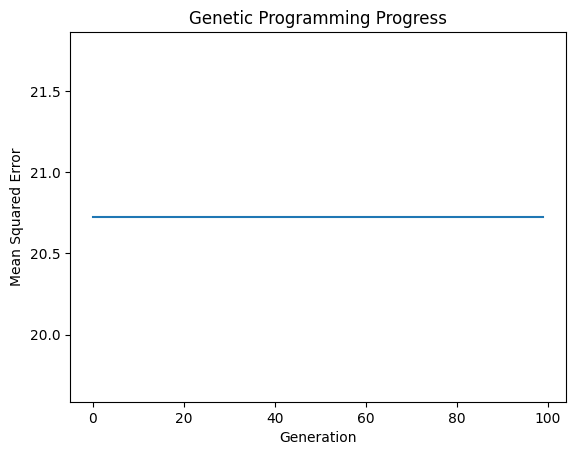

Best function: 9.343487333448618


In [501]:
# Example usage:
# input_data = [(1,), (2,), (3,), (4,)]
# target_outputs = [3, 5, 7, 9]

# Part 1
input_data = generate_inputs(100)  # Generate 100 input data points
target_outputs = [math.atan(x[0]) + 5 for x in input_data]  # Define target outputs for the inputs
available_variables = ['x']

# Part 2
# input_data = generate_inputs(500)  # Generate 500 input data points
# target_outputs = [(x[0]/5 + 1) if x[0] > 0 else (x[0] ** 3 + 5) for x in input_data]  # Define target outputs for the inputs
# available_variables = ['x']

# Part 4
# input_data = generate2D_inputs(500)  # Generate 500 input data points
# target_outputs = [2 * x[0] + 3 * x[1] for x in input_data]  # Define target outputs for the inputs
# available_variables = ['x', 'y']

available_operators = [
    {'symbol': '+', 'arity': 2},
    {'symbol': '-', 'arity': 2},
    {'symbol': '*', 'arity': 2},
    {'symbol': '/', 'arity': 2},
    {'symbol': '^', 'arity': 2},
    {'symbol': 'sin', 'arity': 1},
    {'symbol': 'cos', 'arity': 1}
]


best_function = genetic_programming(input_data, target_outputs, available_operators, available_variables)
print("Best function:", best_function.print_function())